skip 9
skip 22
[[0.2607817351818084, 0.3135411143302917, 0.3331023454666137, 0.3189413249492645, 0.3114047348499298, 0.3017463684082031, 0.3331411182880401, 0.3127935230731964], [0.17825348675251, 0.2204591631889343, 0.244937777519226, 0.2224880754947662, 0.2154709845781326, 0.2091311514377594, 0.2441044300794601, 0.220982477068901], [0.1308217495679855, 0.1549898833036422, 0.1857315301895141, 0.1597310304641723, 0.1535184830427169, 0.1542944014072418, 0.1841063350439071, 0.1630336493253708], [0, 1, 2, 5, 6, 7, 3, 4]]
[[0.0086119277402758, 0.0131004843860864, 0.0348132960498333, 0.0968580842018127, 0.1737132370471954, 0.2469761073589325, 0.3029954731464386, 0.3301739692687988, 0.34156334400177, 0.3394141495227813, 0.3358601927757263, 0.3279896676540375, 0.339219331741333, 0.3489652872085571, 0.3404999375343323, 0.338629275560379, 0.338942676782608, 0.3249052762985229, 0.3344182074069977, 0.3423207700252533, 0.3360249996185303, 0.3341149687767029, 0.3407747745513916, 0.341067761182785],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: x and y must have same first dimension, but have shapes (8,) and (24,)

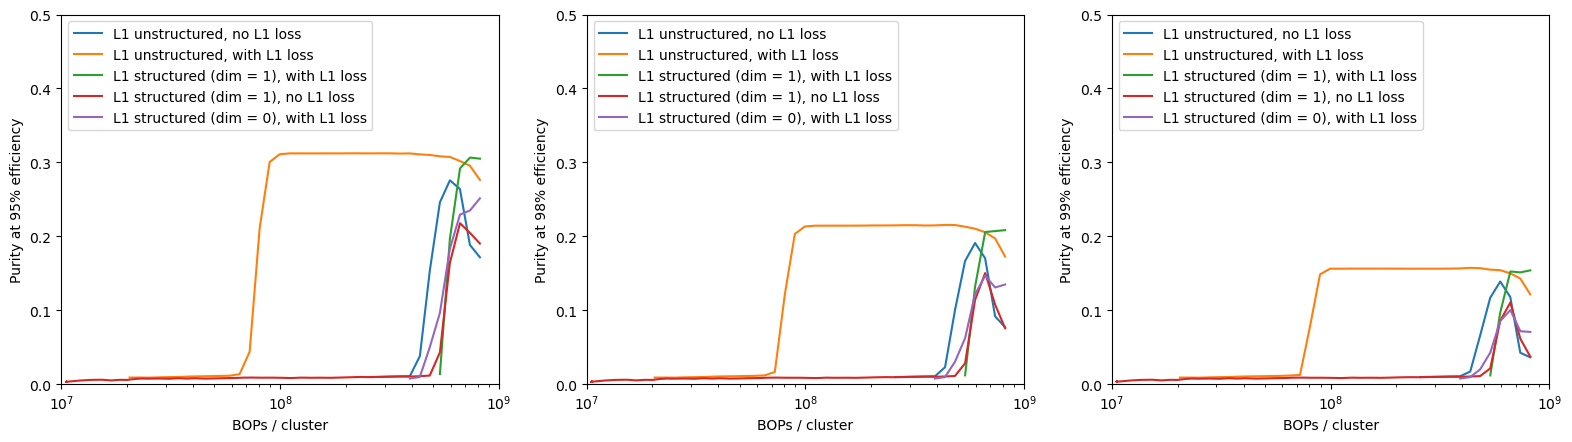

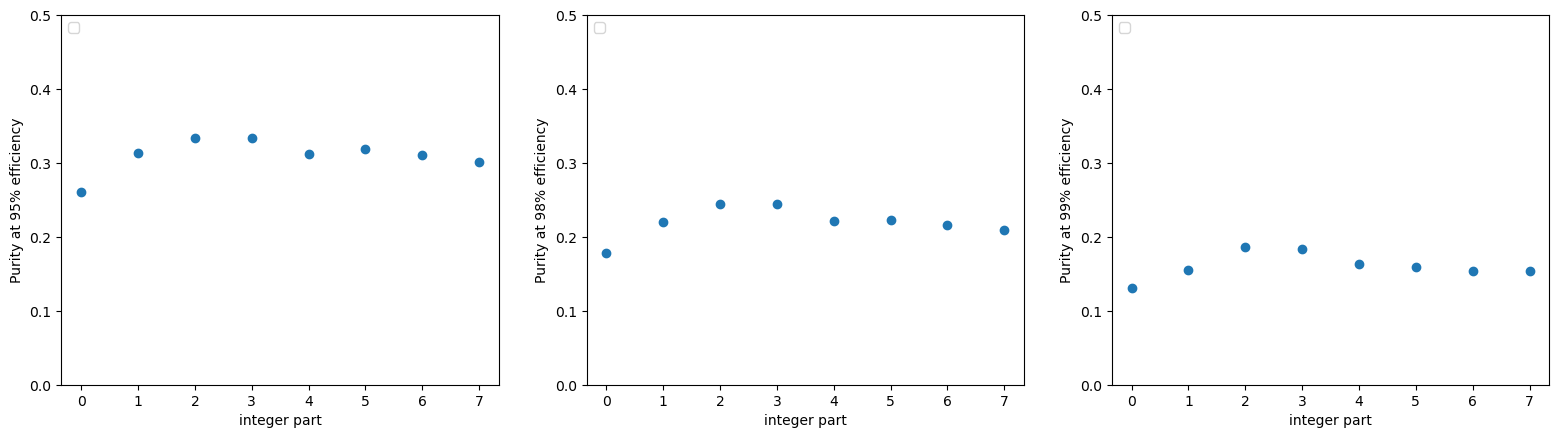

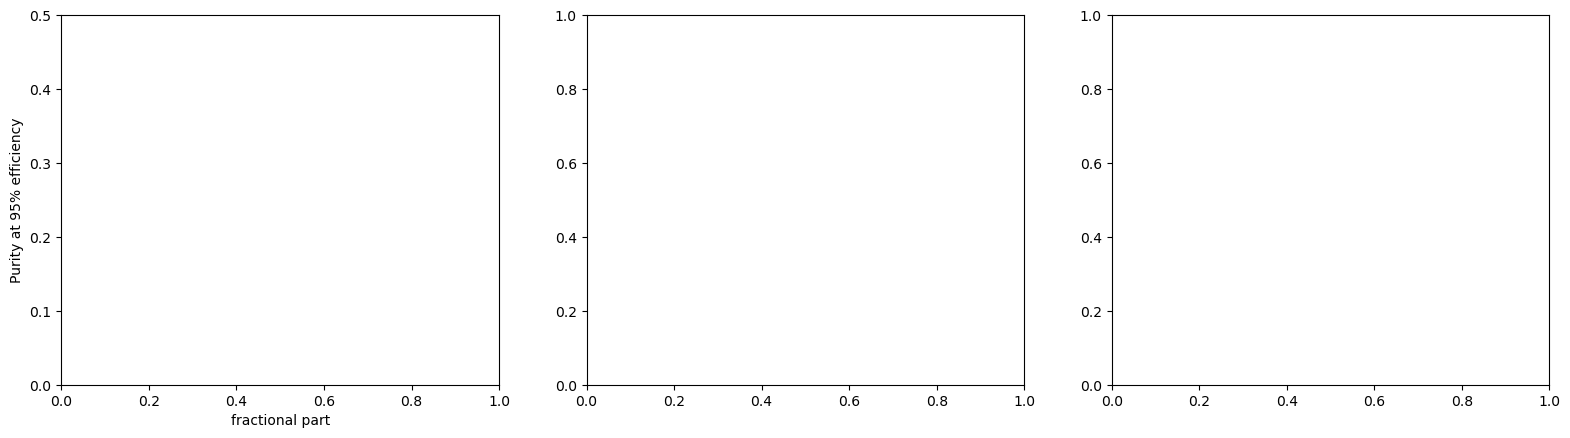

In [38]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from matplotlib import style

def filter_nan(arr): 
     """The way csv file is created for qnn networks, contain some 'nans'
    Therefore I created a function to remove 'nan' from the csv file array"""
     index =np.where( np.isnan(arr)==0)
     filter_arr = arr[index]
     return filter_arr;

def return_final_purities(file_list):
    labels = ['pur_95', 'pur_98', 'pur_99']
    pur95 = []
    pur98 = []
    pur99 = []
    purs = [pur95, pur98, pur99]
    for current_file in file_list:
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
        for purity, label in zip (purs, labels):
            purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
    return purs

def purities_vs_bops(current_file):
    labels = ['pur_95', 'pur_98', 'pur_99', 'total_bops']
    pur95 = []
    pur98 = []
    pur99 = []
    bops  = []
    purs = [pur95, pur98, pur99, bops]
    csv_path = f"{artifacts_path}{current_file}{metrics_file}"
    with open(csv_path) as file:
        metrics = pd.read_csv(file)
        pruned_array = filter_nan(np.array(metrics["pruned"]))
        index_list = []
        last_pruned = 0
        for i in range(len(pruned_array)):
            if(pruned_array[i] > last_pruned):
                index_list.append(i-1)
            last_pruned = pruned_array[i]
        for purity, label in zip (purs, labels):
            for index in index_list :
                purity.append(filter_nan(np.array(metrics[label]))[index]) # taking last value: index -1
    return purs

def purities_vs_config(sweep_dir, num_scans, config_key, skip=[]):
    labels = ['pur_95', 'pur_98', 'pur_99']
    pur95 = []
    pur98 = []
    pur99 = []
    config = []
    purs = [pur95, pur98, pur99]
    for i in range(num_scans):
        if i in skip:
            print(f"skip {i}")
            continue
        current_file = f"{sweep_dir}{i}/"
        yaml_path = f"{artifacts_path}{current_file}{yaml_file}"
        csv_path = f"{artifacts_path}{current_file}{metrics_file}"
        with open(csv_path) as file:
            metrics = pd.read_csv(file)
        j = 7
        for purity, label in zip (purs, labels):
            purity.append(filter_nan(np.array(metrics[label]))[-1]) # taking last value: index -1
        with open(yaml_path) as file:
            all_configs = yaml.load(file, Loader=yaml.FullLoader)
            config.append(all_configs[config_key])
    purs.append(config)
    return purs


# some constants we need
zoom = True

max_epoch = 30
min_xlim = 0
max_bits = 24
min_ylim = [0, 0, 1e-3, 1e-3]
if(zoom):
    min_ylim = [0, 0.95, 1e-3, 1e-3] # for zoom
max_ylim = [0.2, 1, 0.1, 0.1]

linestyles = ['solid', 'densely dotted', 'densely dashed', 'densely dashdotted']
markerstyles = ['o', '^', 'v', 's']
labelloc = [4, 4, 1, 1]

# file lists
artifacts_path = "../../artifacts/chep/metric_learning/"

metrics_file = "metrics.csv"
yaml_file  = "hparams.yaml"

# standard MLP ones
mlp_reference = "reference/version_8/"
mlp_batchnorm = "batchnorm/version_0/"
mlp_batch_noNorm = "batchnorm_no_norm/version_0/"
# pruning of standard MLP
mlp_prune_unstructured_noL1     = "batchnorm_no_norm_prune_unstructured_noL1/version_0/"
mlp_prune_unstructured_wL1      = "batchnorm_no_norm_prune_unstructured_noL1/version_1/"
mlp_prune_structured_wL1_dim1   = "batchnorm_no_norm_prune_structured_wL1/version_1/"
mlp_prune_structured_noL1       = "batchnorm_no_norm_prune_structured_noL1/version_0/"
mlp_prune_structured_wL1_dim0   = "batchnorm_no_norm_prune_structured_wL1/version_2/"
# input quantization in standard MLP; these are sweeps, to be seen how to do!
mlp_input_integer    = "batchnorm_no_norm_inputQuant_integer/version_"
mlp_input_fractional = "batchnorm_no_norm_inputQuant_frac/version_"


files_mlp = [mlp_reference, mlp_batchnorm, mlp_batch_noNorm]
files_mlp_pruned = [mlp_prune_unstructured_noL1, 
                    mlp_prune_unstructured_wL1, 
                    mlp_prune_structured_wL1_dim1, 
                    mlp_prune_structured_noL1, 
                    mlp_prune_structured_wL1_dim0]      
label_files_mlp = ["MLP Layernorm w Normalization",
                   "MLP Batchnorm w Normalization",
                   "MLP Batchnorm w/o Normalization"]
label_files_mlp_prune = ["L1 unstructured, no L1 loss", 
                         "L1 unstructured, with L1 loss", 
                         "L1 structured (dim = 1), with L1 loss",
                         "L1 structured (dim = 1), no L1 loss",
                         "L1 structured (dim = 0), with L1 loss"]
# QMLP: quantized weights and activations, no bias!


obs = {0:"val_loss",
       1:"eff",
       2:"pur",
       3:"current_lr",
       4:"R95",
       5:"R98",
       6:"R99",
       7:"pur_95",
       8:"pur_98",
       9:"pur_99",
       10:"total_bops",
       11:"total_mem_w_bits",
       12:"total_mem_o_bits",
       13:"pruned",
       14:"epoch",
       15:"step",
       16:"train_loss"
      }
label_obs = {0:"Validation loss",
             1:"Efficiency",
             2:"Purity",
             3:"Current learning rate",
             4:"Radius for 95% efficiency",
             5:"Radius for 98% efficiency",
             6:"Radius for 99% efficiency",
             7:"Purity at 95% efficiency",
             8:"Purity at 98% efficiency",
             9:"Purity at 99% efficiency",
             10:"BOPs per cluster/event",
             11:"Memory bits (weights)",
             12:"Memory bits (output, per cluster)",
             13:"Number of pruning steps",
             14:"Epoch",
             15:"Training step",
             16:"Training loss"
      }

reference_purities = return_final_purities(files_mlp)
#print(reference_purities)
pur_vs_bops = []
for file in files_mlp_pruned:
    pur_vs_bops.append(purities_vs_bops(file))
#print(pur_vs_bops[0][0]) #[file][metric]

pur_vs_int = purities_vs_config(mlp_input_integer, 8, "integer_part")
pur_vs_fra = purities_vs_config(mlp_input_fractional, 26, "fractional_part", skip=[9,22])
print(pur_vs_int)
print(pur_vs_fra)

purity_labels = [label_obs[7], label_obs[8], label_obs[9]]

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax_list = [ax1, ax2, ax3]

for pur_file, graph_label in zip(pur_vs_bops, label_files_mlp_prune):
    for ax, lab, pur in zip (ax_list, purity_labels, pur_file):
        ax.set_ylabel(lab)
        ax.set_xscale('log')
        ax.set_ylim(0,0.5)
        ax.set_xlim(1e7,1e9)
        ax.set_xlabel("BOPs / cluster")
        ax.plot(pur_file[3],pur, label = graph_label, alpha=1) #, linestyle=linestyles[idfile%3], marker = markerstyles[idfile%3]) ##plotting )
        ax.legend(loc=2, prop={'size': 10})

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax_list = [ax1, ax2, ax3]    
for ax, lab, pur in zip (ax_list, purity_labels, pur_vs_int):
    ax.set_ylabel(lab)
    ax.set_ylim(0,0.5)
#    ax.set_xlim(1e7,1e9)
    ax.set_xlabel("integer part")
    ax.plot(pur_vs_int[3],pur, alpha=1, linestyle="None", marker = "o") ##plotting )
    ax.legend(loc=2, prop={'size': 10})

fig = plt.figure(figsize=(19.2,4.8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax_list = [ax1, ax2, ax3]    
for ax, lab, pur in zip (ax_list, purity_labels, pur_vs_fra):
    ax.set_ylabel(lab)
    ax.set_ylim(0,0.5)
#    ax.set_xlim(1e7,1e9)
    ax.set_xlabel("fractional part")
    ax.plot(pur_vs_fra[3],pur, alpha=1, linestyle="None", marker = "o") ##plotting )
    ax.legend(loc=2, prop={'size': 10})    
